In [1]:
import pdf2image
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

from utils import *

In [2]:
path = 'data'

for file in os.listdir(path+'/pdf'):
    
    if 'pdf' not in file:
        continue
        
    is_solution = 'solution' in file
    
    level = file.split('.')[0].split('_')[-1]

    pages = pdf2image.convert_from_path(f'{path}/pdf/{file}', dpi=120, fmt='jpeg')
    
    if not is_solution:
        
        for i, img in enumerate(pages):
            
            img.save(f'{path}/pages/{level}_page_{i+1}.jpg', 'JPEG')
            
    else:
        
        for i, img in enumerate(pages):
            
            img.save(f'{path}/solutions/solution_{level}_{i+1}.jpg', 'JPEG')

Each page has six puzzles

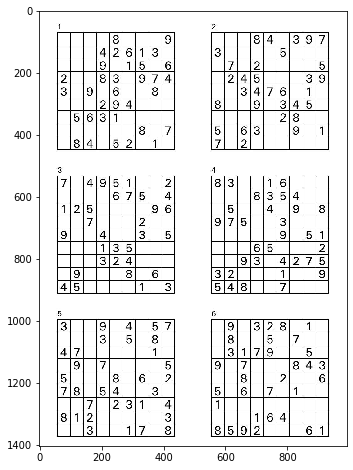

In [3]:
img = plt.imread('data/pages/easy_page_1.jpg')
plot_image(img)

They are evenly distributed so divide them proportionally

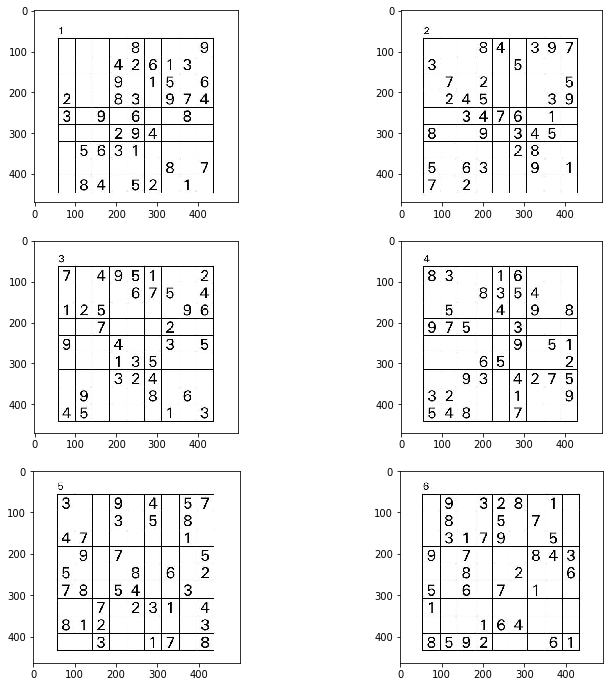

In [4]:
# Manually picked width and height
WIDTH, HEIGHT = 500, 470

fix, ax = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    for j in range(2):
        ax[i][j].imshow(img[HEIGHT*i:HEIGHT*(i+1), WIDTH*j:WIDTH*(j+1)])

Each puzzle has distinct puzzle number above.

In [5]:
# The outer line was thin that without erosion, it could not detect it well
# Make all lines thicker a bit

# First puzzle
p1 = img[:HEIGHT, :WIDTH]

gray = cv2.cvtColor(p1, cv2.COLOR_RGB2GRAY)
gray = cv2.erode(gray, np.ones((3,3)))

contours = cv2.findContours(gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0]

a = gray.copy()
box = []

for c in contours:
    
    rect = cv2.boundingRect(c)
    area = rect[2] * rect[3]
    
    box.append((rect, area))
    
# Sort by area in decreasing order
box.sort(key=lambda x:x[1], reverse=True)

# Skip the first one as it covers the entire image
box = box[1:]

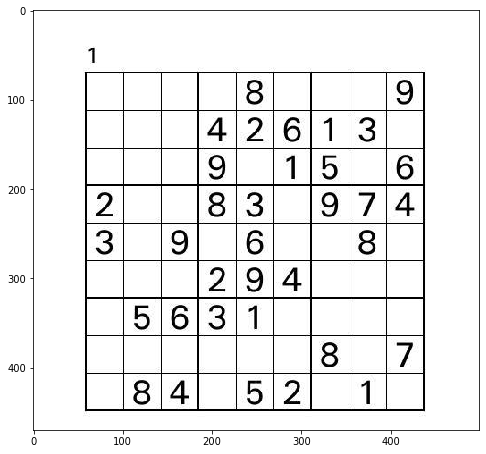

In [18]:
plot_image(p1)

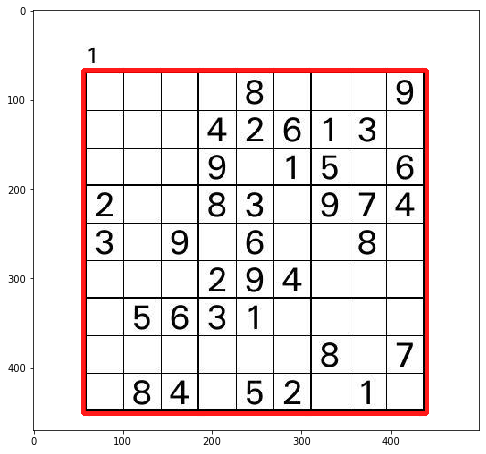

In [6]:
box_used = []
temp_img = p1.copy()

x, y, w, h = box[0][0]

# Add padding around bounding box
# Make sure values are within valid range
x = max(0, x)
y = max(0, y)
w = min(a.shape[0], w)
h = min(a.shape[1], h)

temp_img = cv2.rectangle(temp_img, (x, y), (x+w, y+h), 255, 3)
temp_img = cv2.addWeighted(temp_img, .9, p1, 1-.9, 0)

plot_image(temp_img)

Puzzle number is top left corner above the puzzle

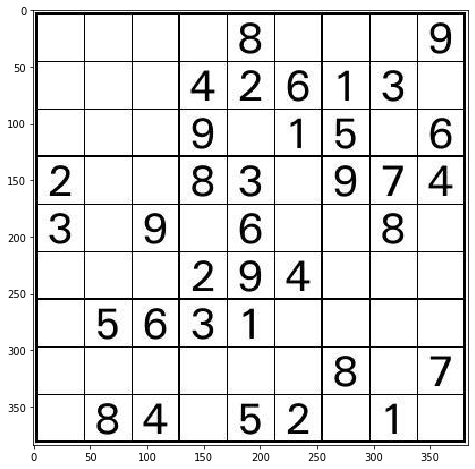

In [7]:
# The contour does not exactly place lines on cover
# Remove those spacing
cropped = p1[y:y+h, x:x+w]

plt.figure(figsize=(8,8))
plt.imshow(cropped)

Combine these two to create a function that returns the bounding boxes of puzzle and label

Since there are too only 30 extreme puzzles, I am also getting 30 from other levels (they have 60 each).

In [82]:
stop = False

for path in ['data/solutions', 'data/pages']:
    for level in ['easy', 'medium', 'hard', 'extreme']:

        pages = os.listdir(path)
        pages = [f for f in pages if level in f]
        
        ROW, COL = 3, 2
        
        is_solution = 'solution' in path
        
        if is_solution:
            WIDTH, HEIGHT = 350, 330
        else:
            WIDTH, HEIGHT = 500, 470
            
        quiz_num = 1

        for num in range(len(pages)):

            if is_solution:
                file_name = 'data/solutions/solution_{}_{}.jpg'.format(level, num+1)
                save_name = 'data/puzzles/{}_{}_solution.csv'
            else:
                file_name = 'data/pages/{}_page_{}.jpg'.format(level, num+1)
                save_name = 'data/puzzles/{}_{}.csv'

            page = plt.imread(file_name)

            if is_solution:
                # The last page of extreme solution has only left side
                if 'extreme_3' in file_name:
                    page = [page]
                    
                else:
                    page = [page[:, :2*WIDTH] ,page[:, WIDTH*2:]]
            else:
                page = [page]
                
            
            print(file_name)
            
            
            for half_page in page:
                
                puzzles = divide_page(half_page, WIDTH, HEIGHT)
                
                for puzzle in puzzles:
                    
                    if quiz_num > 30:
                        
                        step = True
                        break
                        
                    gray = cv2.cvtColor(puzzle, cv2.COLOR_RGB2GRAY)

                    boxes = get_bboxes([gray])
                    puzzle = extract_puzzle([gray], boxes)[0]
                    
                    # This is to match with non-solution puzzles resolution
                    if is_solution:
                        puzzle = cv2.resize(puzzle, (384, 384))
                    
                    puzzle = puzzle[2:380, 2:380]
                    puzzle = clean_puzzle(puzzle, is_solution)
                    
                    pd.DataFrame(puzzle).to_csv(save_name.format(level, quiz_num), index=False)
            
                    quiz_num += 1
                
                if stop:
                    break
            if stop:
                break
        if stop:
            break

data/solutions/solution_easy_1.jpg
data/solutions/solution_easy_2.jpg
data/solutions/solution_easy_3.jpg
data/solutions/solution_easy_4.jpg
data/solutions/solution_easy_5.jpg
data/solutions/solution_medium_1.jpg
data/solutions/solution_medium_2.jpg
data/solutions/solution_medium_3.jpg
data/solutions/solution_medium_4.jpg
data/solutions/solution_medium_5.jpg
data/solutions/solution_hard_1.jpg
data/solutions/solution_hard_2.jpg
data/solutions/solution_hard_3.jpg
data/solutions/solution_hard_4.jpg
data/solutions/solution_hard_5.jpg
data/solutions/solution_extreme_1.jpg
data/solutions/solution_extreme_2.jpg
data/solutions/solution_extreme_3.jpg
data/pages/easy_page_1.jpg
data/pages/easy_page_2.jpg
data/pages/easy_page_3.jpg
data/pages/easy_page_4.jpg
data/pages/easy_page_5.jpg
data/pages/easy_page_6.jpg
data/pages/easy_page_7.jpg
data/pages/easy_page_8.jpg
data/pages/easy_page_9.jpg
data/pages/easy_page_10.jpg
data/pages/medium_page_1.jpg
data/pages/medium_page_2.jpg
data/pages/medium_page